In [1]:
# Simulation Question 1
import numpy as np
from keras.datasets import mnist

def extract_patches(images, patch_size):
    patches = []
    for image in images:
        for i in range(image.shape[0] - patch_size + 1):
            for j in range(image.shape[1] - patch_size + 1):
                patch = image[i:i+patch_size, j:j+patch_size]
                vectorized_patch = patch.reshape(patch_size**2, 1)
                patches.append(vectorized_patch)
    return patches

(train_images, train_labels), (_, _) = mnist.load_data()

subset_images = train_images[:1000]

patch_size = 8

patches = extract_patches(subset_images, patch_size)

patches_array = np.array(patches)

print("Shape of patches array:", patches_array.shape)
print(train_images[0:1])

11490434/11490434 [==============================] - 1s 0us/step
Shape of patches array: (441000, 64, 1)
[[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126
   136 175  26 166 255 247 127   0   0   0   0]
  [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253
   253 225 172 253 242 195  64   0   0   0   0]
  [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253

In [6]:
# Simulation Question 2
from sklearn.mixture import GaussianMixture

num_components = 90

num_patches, patch_rows, patch_cols = patches_array.shape

patches_2d = patches_array.reshape(num_patches, patch_rows * patch_cols)

gmm = GaussianMixture(n_components=num_components)

gmm.fit(patches_2d)

means = gmm.means_
covariances = gmm.covariances_
mixing_coefficients = gmm.weights_

print("Means:\n", means.shape)
print("Covariances:\n", covariances.shape)
print("Mixing Coefficients:\n", mixing_coefficients)

Means:
 (90, 64)
Covariances:
 (90, 64, 64)
Mixing Coefficients:
 [0.00731539 0.15800448 0.0127188  0.00330183 0.00325263 0.0088369
 0.0167045  0.01157099 0.01451911 0.01605404 0.00507196 0.00105227
 0.00210209 0.02982492 0.00797371 0.00176643 0.00079063 0.00513741
 0.00508214 0.00539676 0.01637599 0.00297307 0.00472083 0.00921022
 0.00158717 0.00621789 0.00373707 0.01143029 0.01910533 0.01620488
 0.00246389 0.00743154 0.02464182 0.00770108 0.05723171 0.00066232
 0.01158134 0.0046141  0.00935738 0.00622174 0.04459117 0.00467976
 0.00491142 0.02136227 0.00622912 0.00261248 0.00220646 0.00499365
 0.00788114 0.00411883 0.02727935 0.00326415 0.0141411  0.00130289
 0.00646232 0.00999539 0.00407873 0.0075638  0.00513238 0.01146082
 0.00367689 0.00513068 0.0033515  0.00273137 0.00627699 0.02012899
 0.04745169 0.01919967 0.00388496 0.00229633 0.00283783 0.00741996
 0.00563372 0.01567425 0.00915328 0.01172297 0.00750387 0.00337342
 0.00572828 0.01051099 0.01433348 0.00123517 0.00469322 0.002886

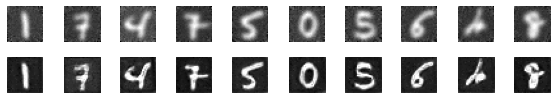

In [ ]:
import numpy as np
from PIL import Image
import os
from scipy.linalg import cholesky
from scipy.stats import multivariate_normal
from scipy import linalg

# Step 1: Load the necessary files
W = np.load("W.npy")
corrupted_images = []
patch_size = 8

corrupted_images_folder = "corrupted_images/"

for filename in os.listdir(corrupted_images_folder):
    if filename.endswith(".png"):
        image_path = os.path.join(corrupted_images_folder, filename)
        image = Image.open(image_path)
        corrupted_images.append(image)


patches = extract_patches(corrupted_images, patch_size)
patches_array = np.array(patches)

denoised_patches = []
K = num_components

for patch in patches_array:
    max_prob = -np.inf
    max_index = 0

    for k in range(K):
        cov_k = covariances[k]
        if not np.allclose(cov_k, cov_k.T):
         cov_k = (cov_k + cov_k.T) / 2
        if not np.all(np.linalg.eigvals(cov_k) > 0):
          min_eigval = np.min(np.real(np.linalg.eigvals(cov_k)))
          cov_k += (-min_eigval + 1e-6) * np.eye(patch_size**2)

        weight_k = mixing_coefficients[k]
        likelihood = multivariate_normal.pdf(patch, means[k], cov_k)
        prob = np.max(weight_k * likelihood)

        if prob > max_prob:
            max_prob = prob
            max_index = k

    denoised_patch = means[max_index].reshape(patch_size, patch_size)
    denoised_patches.append(denoised_patch)


# Reshape denoised patches to m × m size
denoised_images = []

for denoised_patch in denoised_patches:
    denoised_image = denoised_patch.reshape(patch_size, patch_size)
    denoised_images.append(denoised_image)

# Reconstruct denoised images
reconstructed_images = np.zeros((len(corrupted_images), 28, 28))
fig, axes = plt.subplots(2, num_columns, figsize=figure_size)

for i in range(len(corrupted_images)):
    image = corrupted_images[i]
    num_patches = ((28 - patch_size + 1) * (28 - patch_size + 1))

    count_map = np.zeros_like(image)
    sum_map = np.zeros_like(image, dtype=np.float64)


    for j, denoised_patch in enumerate(denoised_images[i*num_patches:(i+1)*num_patches]):
        x = j // (28 - patch_size + 1)
        y = j % (28 - patch_size + 1)

        count_map[x:x+patch_size, y:y+patch_size] += 1
        sum_map[x:x+patch_size, y:y+patch_size] += denoised_patch.astype(np.float64)

    reconstructed_image = sum_map / count_map

    reconstructed_images[i] = reconstructed_image

# Display the noisy image in the first row
axes[0].imshow(corrupted_images[:10], cmap='gray')
axes[0].axis('off')

# Display the denoised image in the second row
axes[1].imshow(denoised_image[:10], cmap='gray')
axes[1].axis('off')

# Adjust the layout and spacing
plt.subplots_adjust(wspace=0.1, hspace=0.4, top=0.3, bottom=0.1)

# Show the figure
plt.show()

m = 4 and k = 90


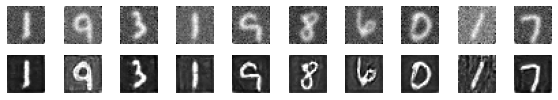

m = 8 and k = 90


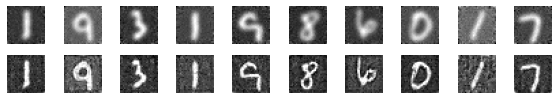

In [ ]:
# Simulation Question 4
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from scipy.stats import multivariate_normal


# Step 1: Load the necessary files
W1 = np.load("W1.npy")
w2 = np.load("W2.npy")
corrupted_images1 = []
corrupted_images2 = []


corrupted_images_folder1 = "corrupted_images1/"

for filename in os.listdir(corrupted_images_folder1):
    if filename.endswith(".png"):
        image_path = os.path.join(corrupted_images_folder1, filename)
        image = Image.open(image_path)
        corrupted_images1.append(image)

corrupted_images_folder2 = "corrupted_images2/"
for filename in os.listdir(corrupted_images_folder2):
    if filename.endswith(".png"):
        image_path = os.path.join(corrupted_images_folder2, filename)
        image = Image.open(image_path)
        corrupted_images2.append(image)



num_patches = (28 - patch_size + 1) ** 2

K_values = [90]  # Number of components
patch_sizes = [4, 8]  # Patch sizes
sigma_values = [5]  # Noise variances

fig, axes = plt.subplots(len(K_values), len(patch_sizes) + 1, figsize=(12, 8))

for i, K in enumerate(K_values):
    gmm = GaussianMixture(n_components=K)
    gmm.fit(patches_2d)
    means = gmm.means_
    covariances = gmm.covariances_
    mixing_coefficients = gmm.weights_

    axes[i, 0].set_ylabel(f"K={K}")

    for j, patch_size in enumerate(patch_sizes):
        patches = extract_patches(corrupted_images, patch_size)
        patches_array = np.array(patches)

        denoised_patches = []

        for patch in patches_array:
            max_prob = -np.inf
            max_index = 0

            for k in range(K):
                cov_k = covariances[k]

                if not np.allclose(cov_k, cov_k.T):
                    cov_k = (cov_k + cov_k.T) / 2

                if not np.all(np.linalg.eigvals(cov_k) > 0):
                    min_eigval = np.min(np.real(np.linalg.eigvals(cov_k)))
                    cov_k += (-min_eigval + 1e-6) * np.eye(patch_size**2)

                weight_k = mixing_coefficients[k]
                likelihood = multivariate_normal.pdf(patch, means[k], cov_k)
                prob = weight_k * likelihood

                if prob > max_prob:
                    max_prob = prob
                    max_index = k

            denoised_patch = means[max_index].reshape(patch_size, patch_size)
            denoised_patches.append(denoised_patch)

        denoised_images = np.zeros((num_patches, patch_size, patch_size))

        for k, denoised_patch in enumerate(denoised_patches):
            x = k // (28 - patch_size + 1)
            y = k % (28 - patch_size + 1)
            denoised_images[x:x+patch_size, y:y+patch_size] = denoised_patch

        reconstructed_image = np.zeros((28, 28))
        count_map = np.zeros((28, 28))

        for k in range(num_patches):
            x = k // (28 - patch_size + 1)
            y = k % (28 - patch_size + 1)
            reconstructed_image[x:x+patch_size, y:y+patch_size] += denoised_images[k]
            count_map[x:x+patch_size, y:y+patch_size] += 1

        reconstructed_image /= count_map

        axes[i, j+1].imshow(reconstructed_image, cmap='gray')
        axes[i, j+1].axis('off')
        axes[i, j+1].set_title(f"m={patch_size}")

plt.subplots_adjust(wspace=0.1, hspace=0.4, top=0.95, bottom=0.05)
plt.show()